# Guess the age 2022-2023
Group 9:
*   Antonello Avella
*   Eugenio Carpentieri
*   Valerio Costantino
*   Claudio De Pisapia



## Init

In [ ]:
%pip install deepface opencv-python scipy keras_vggface tensorflow keras_applications scikit-learn

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np

from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten

from keras.utils import plot_model
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import keras

## Dataset loading and Generator

In [ ]:
%cd '/content'

In [ ]:
# DOWNLOAD THE FULL DATASET FROM KAGGLE
# To execute properly this cell you must be in "/content" folder.
# Moreover, inside "/content" folder ther must be a file named 'kaggle.json' (thanks to which the download can start).
# At the end of download, you can find the full dataset in "/content/dataset/training_caip_contest".

!pip install -q kaggle
!rm -r ~/.kaggle 
!mkdir ~/.kaggle
!mkdir dataset
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d robertofalcone/gta2022dataset 
!unzip gta2022dataset.zip -d dataset 

# You should also upload 'training_caip_contest.csv' in "/content/dataset/" in order to execute the next cells.

In [ ]:
data_dir = './training_caip_contest/' #change to choose a different training set

In [ ]:
df = pd.read_csv('./training_caip_contest.csv', names=['path', 'age'])
df.loc[np.less_equal(df['age'],10), 'group'] = '1'
df.loc[np.logical_and(df['age'].gt(10), np.less_equal(df['age'],20)), 'group'] = '2'
df.loc[np.logical_and(df['age'].gt(20), np.less_equal(df['age'],30)), 'group'] = '3'
df.loc[np.logical_and(df['age'].gt(30), np.less_equal(df['age'],40)), 'group'] = '4'
df.loc[np.logical_and(df['age'].gt(40), np.less_equal(df['age'],50)), 'group'] = '5'
df.loc[np.logical_and(df['age'].gt(50), np.less_equal(df['age'],60)), 'group'] = '6'
df.loc[np.logical_and(df['age'].gt(60), np.less_equal(df['age'],70)), 'group'] = '7'
df.loc[df['age'].gt(70), 'group'] = '8'

bins = [-1, 10, 20, 30, 40, 50, 60, 70, np.inf]
labels=['0-10','11-20','21-30', '31-40', '41-50', '51-60', '61-70', '70+']
count_groups = df.groupby(pd.cut(df['age'], bins=bins, labels=labels)).size().reset_index(name='count')
print(count_groups)

     age   count
0   0-10    2008
1  11-20   28517
2  21-30  147443
3  31-40  150010
4  41-50  128253
5  51-60   88489
6  61-70   27871
7    70+    2482


In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True,
                 dataset_path="./"
                 ):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.n_group_age = df[y_col['group']].nunique()
        self.random_state = np.random.RandomState(1)
        self.dataset_path = dataset_path
        self.data_aug = ImageDataGenerator(brightness_range=[0.5,1.0], horizontal_flip=True, fill_mode='nearest')

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, path, target_size):
        image = tf.keras.preprocessing.image.load_img(self.dataset_path + path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        augment = np.random.choice(a=[True, False])
        if augment:
          image_arr = np.expand_dims(image_arr, 0)
          it = self.data_aug.flow(image_arr, batch_size=1)
          image_arr = it.next()
          image_arr = np.squeeze(image_arr, axis=0)
        return image_arr/255.

    def __get_output(self, label):
        return np.array(label/100.)

    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['path']]
        age_batch = batches[self.y_col['age']]
        X_batch = np.asarray([self.__get_input(path, self.input_size) for path in path_batch])
        y_batch = np.asarray([self.__get_output(age) for age in age_batch])
        return X_batch, y_batch

    def __getitem__(self, index):
        grouped = self.df.groupby(self.y_col['group'])
        batches = pd.DataFrame()
        for i in range(1,9):
          length = len(grouped.get_group(str(i)))
          first_index = int(index*(batch_size//self.n_group_age)%length)
          final_index = int((index + 1)*(batch_size//self.n_group_age)%length)
          if first_index > final_index:
            batches = pd.concat([batches, grouped.get_group(str(i)).iloc[first_index:], grouped.get_group(str(i)).iloc[:final_index]])
          else:  
            batches = pd.concat([batches, grouped.get_group(str(i)).iloc[first_index:final_index]])
        X, y = self.__get_data(batches)        
        return X, y

    def __len__(self):
        return self.n // self.batch_size

In [ ]:
val_df = df.groupby('group').sample(frac=.2, random_state=1)
merged = pd.merge(df, val_df, how='outer', indicator=True)
train_df = merged.loc[merged._merge == 'left_only'].drop('_merge', axis=1)

bins = [-1, 10, 20, 30, 40, 50, 60, 70, np.inf]
labels=['0-10','11-20','21-30', '31-40', '41-50', '51-60', '61-70', '70+']
count_train_groups = train_df.groupby(pd.cut(train_df['age'], bins=bins, labels=labels)).size().reset_index(name='count')
count_val_groups = val_df.groupby(pd.cut(val_df['age'], bins=bins, labels=labels)).size().reset_index(name='count')

n_train_samples = len(train_df)
n_val_samples = len(val_df)

print(count_train_groups)
print(count_val_groups)

In [ ]:
img_width, img_height = 299, 299   # resize dimensions of our images
batch_size = 32                   # number of images in a batch

%cd /content/dataset/training_caip_contest

train_gen = CustomDataGen(train_df,
                         X_col={'path':'path'},
                         y_col={'age': 'age', 'group': 'group'},
                         batch_size=batch_size, input_size=(img_width, img_height, 3))
val_gen = CustomDataGen(val_df,
                         X_col={'path':'path'},
                         y_col={'age': 'age', 'group': 'group'},
                         batch_size=batch_size, input_size=(img_width, img_height, 3))

## Loss function

In [ ]:
@tf.function
def AAR_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mae_fun = tf.keras.losses.MeanAbsoluteError()
    mae = mae_fun(y_true, y_pred)

    condition = tf.less_equal(y_true, 0.1)
    indices = tf.where(condition)
    mae_1 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_1 = tf.square(mae_1-mae)

    condition1 = tf.less_equal(y_true, 0.2)
    condition2 = tf.greater(y_true, 0.1)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_2 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_2 = tf.square(mae_2-mae)

    condition1 = tf.less_equal(y_true, 0.3)
    condition2 = tf.greater(y_true, 0.2)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_3 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_3 = tf.square(mae_3-mae)

    condition1 = tf.less_equal(y_true, 0.4)
    condition2 = tf.greater(y_true, 0.3)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_4 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_4 = tf.square(mae_4-mae)

    condition1 = tf.less_equal(y_true, 0.5)
    condition2 = tf.greater(y_true, 0.4)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_5 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_5 = tf.square(mae_5-mae)

    condition1 = tf.less_equal(y_true, 0.6)
    condition2 = tf.greater(y_true, 0.5)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_6 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_6 = tf.square(mae_6-mae)

    condition1 = tf.less_equal(y_true, 0.7)
    condition2 = tf.greater(y_true, 0.6)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_7 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_7 = tf.square(mae_7-mae)

    condition = tf.greater(y_true, 0.7)
    indices = tf.where(condition)
    mae_8 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_8 = tf.square(mae_8-mae)

    mae_temp = tf.stack([mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7, mae_8], axis=0)
    indices = tf.where(tf.logical_not(tf.math.is_nan(mae_temp)))
    mae_total = tf.gather(mae_temp, indices)
    mmae = tf.reduce_mean(mae_total)
    mae_diff_temp = tf.stack([mae_diff_1, mae_diff_2, mae_diff_3, mae_diff_4, mae_diff_5, mae_diff_6, mae_diff_7, mae_diff_8])
    variance_temp = tf.gather(mae_diff_temp, indices)
    variance = tf.sqrt(tf.reduce_mean(variance_temp))

    AAR_loss = 0.5*mmae + 0.5*variance

    return AAR_loss

## Custom Metric

In [ ]:
@tf.function
def AAR_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mae_fun = tf.keras.losses.MeanAbsoluteError()
    mae = mae_fun(y_true, y_pred)

    condition = tf.less_equal(y_true, 0.1)
    indices = tf.where(condition) 
    mae_1 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_1 = tf.square(mae_1-mae)

    condition1 = tf.less_equal(y_true, 0.2)
    condition2 = tf.greater(y_true, 0.1)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_2 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_2 = tf.square(mae_2-mae)

    condition1 = tf.less_equal(y_true, 0.3)
    condition2 = tf.greater(y_true, 0.2)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_3 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_3 = tf.square(mae_3-mae)

    condition1 = tf.less_equal(y_true, 0.4)
    condition2 = tf.greater(y_true, 0.3)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_4 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_4 = tf.square(mae_4-mae)

    condition1 = tf.less_equal(y_true, 0.5)
    condition2 = tf.greater(y_true, 0.4)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_5 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_5 = tf.square(mae_5-mae)

    condition1 = tf.less_equal(y_true, 0.6)
    condition2 = tf.greater(y_true, 0.5)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_6 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_6 = tf.square(mae_6-mae)

    condition1 = tf.less_equal(y_true, 0.7)
    condition2 = tf.greater(y_true, 0.6)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_7 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_7 = tf.square(mae_7-mae)

    condition = tf.greater(y_true, 0.7)
    indices = tf.where(condition)
    mae_8 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_8 = tf.square(mae_8-mae)

    mae_temp = tf.stack([mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7, mae_8], axis=0)
    indices = tf.where(tf.logical_not(tf.math.is_nan(mae_temp)))
    mae_total = tf.gather(mae_temp, indices)
    mmae = tf.reduce_mean(mae_total)
    mae_diff_temp = tf.stack([mae_diff_1, mae_diff_2, mae_diff_3, mae_diff_4, mae_diff_5, mae_diff_6, mae_diff_7, mae_diff_8])
    variance_temp = tf.gather(mae_diff_temp, indices)
    variance = tf.sqrt(tf.reduce_mean(variance_temp))

    #𝐴𝐴𝑅 = max(0; 5 − 𝑚𝑀𝐴𝐸) + max(0; 5 − 𝜎)
    AAR = tf.math.maximum(tf.zeros((1,)),tf.constant(5, dtype=tf.float32)-mmae*100)+tf.math.maximum(tf.zeros((1,)),tf.constant(5, dtype=tf.float32)-variance*100)

    return AAR

## Xception model

In [ ]:
model = tf.keras.applications.Xception(
    input_shape=(299,299,3),
     include_top=False,
     weights="imagenet")
model.trainable = False
model.summary()

Model: "Final_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
____________________________________

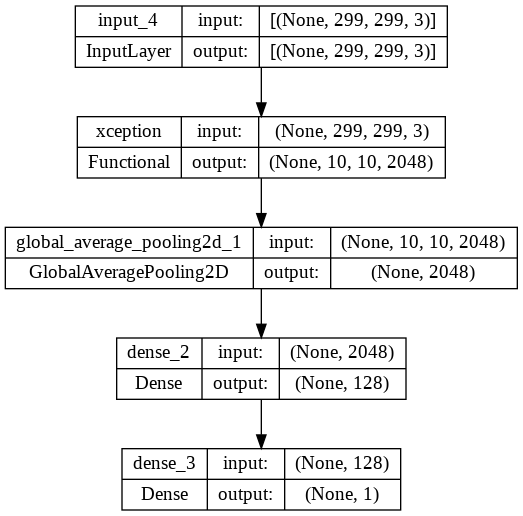

In [ ]:
input = Input(shape=(299, 299, 3))

x = model(input, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
final_model_output = Dense(1, activation='linear')(x)

final_model = Model(inputs=[input], outputs=final_model_output,
                    name='Final_output')

final_model.summary()

## Training final layers

In [ ]:
final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.), loss=AAR_loss, metrics=["mae", AAR_metric])

epochs = 100
final_model.fit(
    train_gen,
    workers=20,
    steps_per_epoch=(n_train_samples) // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=n_val_samples // batch_size,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/' + 'xception09_initial_training', monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor="val_loss", patience=3)])


Epoch 1/100
7188/7188 [==============================] - ETA: 0s - loss: 0.0606 - mae: 0.1048 - AAR_metric: 1.3284

7188/7188 [==============================] - 8324s 1s/step - loss: 0.0606 - mae: 0.1048 - AAR_metric: 1.3284 - val_loss: 0.0648 - val_mae: 0.1051 - val_AAR_metric: 1.0638
Epoch 2/100
7188/7188 [==============================] - 8489s 1s/step - loss: 0.0535 - mae: 0.0934 - AAR_metric: 1.6421 - val_loss: 0.0664 - val_mae: 0.0953 - val_AAR_metric: 1.7117
Epoch 3/100
7188/7188 [==============================] - ETA: 0s - loss: 0.0501 - mae: 0.0888 - AAR_metric: 1.8470

7188/7188 [==============================] - 8525s 1s/step - loss: 0.0501 - mae: 0.0888 - AAR_metric: 1.8470 - val_loss: 0.0642 - val_mae: 0.0984 - val_AAR_metric: 1.3712
Epoch 4/100
7188/7188 [==============================] - 8530s 1s/step - loss: 0.0475 - mae: 0.0850 - AAR_metric: 2.0346 - val_loss: 0.0661 - val_mae: 0.0925 - val_AAR_metric: 1.7529
Epoch 5/100
7188/7188 [==============================] - ETA: 0s - loss: 0.0460 - mae: 0.0829 - AAR_metric: 2.1340

7188/7188 [==============================] - 8468s 1s/step - loss: 0.0460 - mae: 0.0829 - AAR_metric: 2.1340 - val_loss: 0.0639 - val_mae: 0.0935 - val_AAR_metric: 1.5444
Epoch 6/100
7188/7188 [==============================] - 8519s 1s/step - loss: 0.0446 - mae: 0.0804 - AAR_metric: 2.2551 - val_loss: 0.0659 - val_mae: 0.0882 - val_AAR_metric: 1.8478
Epoch 7/100
7188/7188 [==============================] - 8532s 1s/step - loss: 0.0427 - mae: 0.0776 - AAR_metric: 2.4035 - val_loss: 0.0667 - val_mae: 0.0904 - val_AAR_metric: 1.6877
Epoch 8/100
7188/7188 [==============================] - ETA: 0s - loss: 0.0422 - mae: 0.0765 - AAR_metric: 2.4681

7188/7188 [==============================] - 8511s 1s/step - loss: 0.0422 - mae: 0.0765 - AAR_metric: 2.4681 - val_loss: 0.0617 - val_mae: 0.0887 - val_AAR_metric: 1.8614
Epoch 9/100
7188/7188 [==============================] - 8507s 1s/step - loss: 0.0408 - mae: 0.0743 - AAR_metric: 2.5921 - val_loss: 0.0663 - val_mae: 0.0861 - val_AAR_metric: 1.8931
Epoch 10/100
7188/7188 [==============================] - ETA: 0s - loss: 0.0402 - mae: 0.0732 - AAR_metric: 2.6656

7188/7188 [==============================] - 8571s 1s/step - loss: 0.0402 - mae: 0.0732 - AAR_metric: 2.6656 - val_loss: 0.0610 - val_mae: 0.0854 - val_AAR_metric: 1.9581
Epoch 11/100
 664/7188 [=>............................] - ETA: 1:45:25 - loss: 0.0415 - mae: 0.0748 - AAR_metric: 2.5448

## Fine tuning


In [ ]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/xception09_initial_training', compile=False)
final_model.trainable = True

final_model.summary()
plot_model(final_model, to_file='finalmodel_plot.png', show_shapes=True, show_layer_names=True)

final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.), loss=AAR_loss, metrics=["mae", AAR_metric])

epochs = 100

lr_manager = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

Model: "Final_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 21,069,353
Non-trainable params: 54,528
_____________________________________

In [ ]:
final_model.fit(
    train_gen,
    workers=25,
    steps_per_epoch=(n_train_samples) // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=n_val_samples // batch_size,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/' + 'xception09_final', monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor="val_loss", patience=5),lr_manager])

Epoch 1/100
14376/14376 [==============================] - ETA: 0s - loss: 0.0069 - mae: 0.0121 - AAR_metric: 8.6282

14376/14376 [==============================] - 21246s 1s/step - loss: 0.0069 - mae: 0.0121 - AAR_metric: 8.6282 - val_loss: 0.0075 - val_mae: 0.0123 - val_AAR_metric: 8.4994 - lr: 1.0000e-06
Epoch 2/100
14376/14376 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0120 - AAR_metric: 8.6461

14376/14376 [==============================] - 21489s 1s/step - loss: 0.0068 - mae: 0.0120 - AAR_metric: 8.6461 - val_loss: 0.0072 - val_mae: 0.0122 - val_AAR_metric: 8.5597 - lr: 1.0000e-06
 